# Installations

In [1]:
!pip install matplotlib 

# Imports and Sparksession

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import os
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import numpy as np
import pandas as pd
from pyspark.ml.stat import Correlation
import seaborn as sns



In [2]:
spark = SparkSession.builder.appName("accidents").getOrCreate()

In [ ]:
accidents = spark.read.csv("work/datasets/US_Accidents_March23.csv", header=True, inferSchema=True)
#Per tagliare lineage:
accidents = accidents.cache()
accidents.count()


# EDA

## show columns and initial ds

In [ ]:
accidents_sample = accidents.sample(False, 0.0005, seed=42)  # 0.05%
accidents_sample.show()
accidents_sample.toPandas().hist(figsize=(10,10))


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [6]:
print(accidents.columns)

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


## plot labels (severity distribution)

In [7]:


# 1 Raggruppa severity (Spark → veloce su 7M righe)
severity_counts = (
    accidents.groupBy("severity")
             .count()
             .orderBy("severity")
)

# 2️ Converte in Pandas (poche righe → ok)
pdf = severity_counts.toPandas()

# 3️Calcolo percentuali
pdf["percent"] = pdf["count"] / pdf["count"].sum() * 100




0     0.871669
1    79.667017
2    16.812510
3     2.648804
Name: percent, dtype: float64


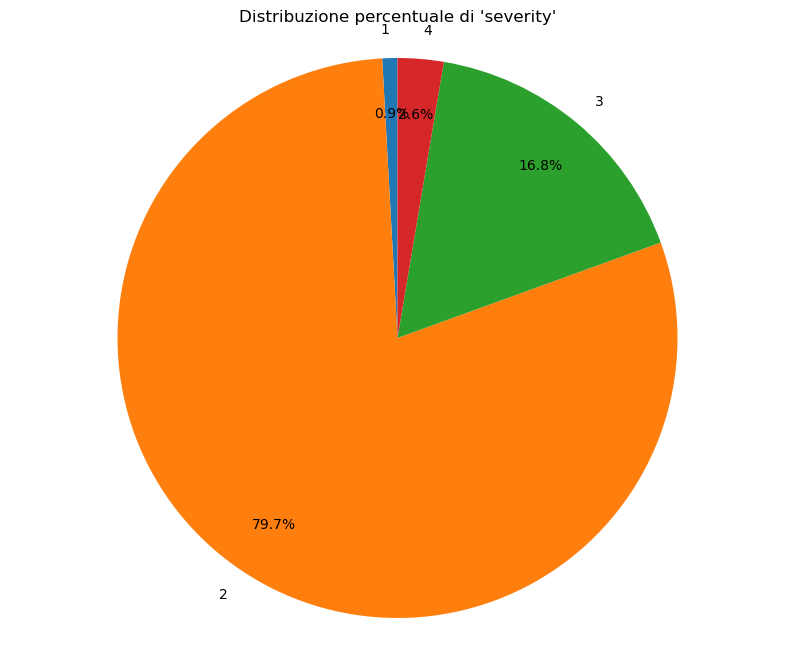

In [8]:
print(pdf["percent"])
# 4️⃣ Grafico a torta
plt.figure(figsize=(10, 8))
plt.pie(
    pdf["count"],
    labels=pdf["severity"],
    autopct=lambda p: f"{p:.1f}%",    # percentuali con 1 decimale
    startangle=90,
    pctdistance=0.8
)
plt.title("Distribuzione percentuale di 'severity'")
plt.axis("equal")  # mantiene il cerchio perfettamente rotondo
plt.show()

## Fill NaN with median

In [ ]:
mean_temp = accidents.select(F.mean("Temperature(F)")).first()[0]

accidents = accidents.fillna({"Temperature(F)": mean_temp})

In [ ]:
weather_numeric = ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']
    
for col in weather_numeric:
    mean = accidents.select(F.mean(col)).first()[0]
    accidents = accidents.fillna({col: mean})
#Per tagliare lineage:
accidents = accidents.cache()
accidents.count()

## Drop unuseful columns

End_* columns are removed because aren't useful to predict the severity (can be defined only afterwards the incident)
Weather_Timestamp is a value near the initial timestamp

In [ ]:
#accidents = accidents.drop('Astronomical_Twilight', 'Nautical_Twilight','Country')
accidents = accidents.drop('ID', "Source",'Description', 'Distance', 'End_Time', 'Distance(mi)', 'End_Lng', 'End_Lat', 'Duration',"Weather_Timestamp")

## define categorical features

In [ ]:
cat_names = ['Street', 'City', 'County', 'State', "Zipcode",
             'Timezone', 'Airport_Code', 'Wind_Direction',
              'Weather_Condition','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
            "Sunrise_Sunset","Country","Turning_Loop","Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", 
            "Roundabout", "Station","Stop","Traffic_Calming",
             "Traffic_Signal"]

## analyze categorical features

In [ ]:

print("Unique count of categorical features:")
for col in cat_names:
    count_unique = accidents.select(F.countDistinct(col)).first()[0]
    print(f"{col}: {count_unique}")

Unique count of categorical features:
Street: 336306
City: 13678
County: 1871
State: 49
Zipcode: 825094
Timezone: 4
Airport_Code: 2045
Wind_Direction: 24
Weather_Condition: 144
Sunrise_Sunset: 2
Civil_Twilight: 2
Nautical_Twilight: 2
Astronomical_Twilight: 2
Sunrise_Sunset: 2
Country: 1
Turning_Loop: 1
Amenity: 2
Bump: 2
Crossing: 2
Give_Way: 2
Junction: 2
No_Exit: 2
Railway: 2
Roundabout: 2
Station: 2
Stop: 2
Traffic_Calming: 2
Traffic_Signal: 2


## Drop categorical with 1 unique value

In [ ]:
accidents = accidents.drop("Country","Turning_Loop")
cat_names.remove("Country")
cat_names.remove("Turning_Loop")


## simplify wind direction 
from 24 values to 10

In [ ]:
print("Wind Direction: ")
accidents.select("Wind_Direction").distinct().show()


Wind Direction: 
+--------------+
|Wind_Direction|
+--------------+
|           SSE|
|            SW|
|            NW|
|          Calm|
|             E|
|           WSW|
|           ENE|
|            NE|
|         South|
|           NNW|
|             N|
|           SSW|
|             W|
|             S|
|            SE|
|          East|
|           WNW|
|           NNE|
|          West|
|           VAR|
+--------------+
only showing top 20 rows



In [ ]:
wind_dir_mapping = {
    "North": 'N',
    'NNE': 'NE',
    'NE': 'NE',
    'ENE': 'E',
    'East': 'E',
    'ESE': 'SE',
    'SE': 'SE',
    'SSE': 'S',
    'South': 'S',
    'SSW': 'SW',
    'SW': 'SW',
    'WSW': 'W',
    'West': 'W',
    'WNW': 'NW',
    'NW': 'NW',
    'NNW': 'NW',
    "Calm":"CALM",
    "Variable":"VAR"
}
accidents = accidents.replace(wind_dir_mapping, subset=['Wind_Direction'])
print("Wind Direction after simplification: ")
accidents.select("Wind_Direction").distinct().show()

Wind Direction after simplification: 
+--------------+
|Wind_Direction|
+--------------+
|            SW|
|            NW|
|             E|
|            NE|
|             N|
|             W|
|             S|
|            SE|
|           VAR|
|          CALM|
|          NULL|
+--------------+



## simplify wehater_condition

In [ ]:
accidents.select("Weather_Condition").distinct().show(150)

+-----------------+
|Weather_Condition|
+-----------------+
|       Heavy_Rain|
|              Fog|
|            Clear|
|       Heavy_Snow|
|             Rain|
|             Snow|
|            Cloud|
|             NULL|
+-----------------+



In [ ]:
patterns = {
    "Clear": "Clear",
    "Cloud": "Cloud|Overcast",
    "Rain": "Rain|storm",
    "Heavy_Rain": "Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms",
    "Snow": "Snow|Sleet|Ice",
    "Heavy_Snow": "Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls",
    "Fog": "Fog"
}

# inizia con colonna vuota
expr = F.lit(None)

for category, pattern in patterns.items():
    expr = F.when(
        F.col("Weather_Condition").rlike(f"(?i){pattern}"), 
        category
    ).otherwise(expr)
    
accidents = accidents.withColumn("Weather_Condition", expr)
accidents.select("Weather_Condition").distinct().show(150)

+-----------------+
|Weather_Condition|
+-----------------+
|              Fog|
|            Clear|
|             Rain|
|             Snow|
|            Cloud|
|             NULL|
+-----------------+



## Conversione timestamps

In [ ]:
accidents = accidents.withColumn(
    "Start_Time_parsed_str",
    F.substring(F.col("Start_Time"), 1, 19)
)

# Converte in timestamp usando il formato specifico
accidents = accidents.withColumn(
    "Start_Time_parsed",
    F.to_timestamp("Start_Time_parsed_str", "yyyy-MM-dd HH:mm:ss")
)

accidents.select("Start_Time_parsed").show(10, truncate=False)

+-------------------+
|Start_Time_parsed  |
+-------------------+
|2016-02-08 05:46:00|
|2016-02-08 06:07:59|
|2016-02-08 06:49:27|
|2016-02-08 07:23:34|
|2016-02-08 07:39:07|
|2016-02-08 07:44:26|
|2016-02-08 07:59:35|
|2016-02-08 07:59:58|
|2016-02-08 08:00:40|
|2016-02-08 08:10:04|
+-------------------+
only showing top 10 rows



### Gestione date con nuovi dati estrapolati

In [ ]:
# -----------------------------
# 1) Date features
# -----------------------------
accidents = accidents.withColumn("Hour",  F.hour("Start_Time_parsed") + 1)
accidents = accidents.withColumn("Day",   F.dayofweek("Start_Time_parsed"))  # Spark: 1 = Sunday
accidents = accidents.withColumn("Month", F.month("Start_Time_parsed"))
accidents = accidents.withColumn("Year",  F.year("Start_Time_parsed"))

# -----------------------------
# 4) Part_of_Day (cut)
# -----------------------------
accidents = accidents.withColumn(
    "Part_of_Day",
    F.when(F.col("Hour").between(1, 6),  "Night")
     .when(F.col("Hour").between(7, 12), "Morning")
     .when(F.col("Hour").between(13, 18),"Afternoon")
     .otherwise("Evening")
)

# -----------------------------
# 5) Sunrise_Sunset (Day/Night)
# -----------------------------
accidents = accidents.withColumn(
    "Sunrise_Sunset",
    F.when(F.col("Hour").between(1, 16), "Day")
     .otherwise("Night")
)

# -----------------------------
# 6) Show results
# -----------------------------
accidents.select("Hour", "Day", "Month", "Year", "Part_of_Day", "Sunrise_Sunset").show(10)


+----+---+-----+----+-----------+--------------+
|Hour|Day|Month|Year|Part_of_Day|Sunrise_Sunset|
+----+---+-----+----+-----------+--------------+
|   6|  2|    2|2016|      Night|           Day|
|   7|  2|    2|2016|    Morning|           Day|
|   7|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   8|  2|    2|2016|    Morning|           Day|
|   9|  2|    2|2016|    Morning|           Day|
|   9|  2|    2|2016|    Morning|           Day|
+----+---+-----+----+-----------+--------------+
only showing top 10 rows



In [ ]:
accidents = accidents.drop("Start_Time_parsed","Start_Time", "Start_Time_parsed_str")
accidents=accidents.drop("Weather_Timestamp")

## Analisys of NaN

In [ ]:

# Numero totale di righe
total_rows = accidents.count()

# Calcolo missing per ogni colonna
missing_df = accidents.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / total_rows * 100)
    .alias(c)
    for c in accidents.columns
])

# Converti in pandas per lo stesso stile tabellare
missing_pd = missing_df.toPandas().T.reset_index()

# Rename colonne per essere identici al tuo output Pandas
missing_pd.columns = ["Feature", "Missing_Percent(%)"]

# Filtra solo le colonne con missing > 0%
missing_pd = missing_pd[missing_pd["Missing_Percent(%)"] > 0]

missing_pd

,Feature,Missing_Percent(%)
3,Street,0.140637
4,City,0.003274
7,Zipcode,0.024779
8,Timezone,0.101030
9,Airport_Code,0.292881
15,Wind_Direction,2.267043
18,Weather_Condition,38.088237
32,Civil_Twilight,0.300787
33,Nautical_Twilight,0.300787
34,Astronomical_Twilight,0.300787


## Substitute NaN with "Unknown"

In [ ]:
accidents = accidents.withColumn(
    "Street",
    F.coalesce(F.col("Street"), F.lit("Unknown"))
)

accidents = accidents.withColumn(
    "Zipcode",
    F.coalesce(F.col("Zipcode"), F.lit("Unknown"))
)

accidents = accidents.withColumn(
    "Weather_Condition",
    F.coalesce(F.col("Weather_Condition"), F.lit("Unknown"))
)

accidents = accidents.withColumn(
    "Wind_Direction",
    F.coalesce(F.col("Wind_Direction"), F.lit("Unknown"))
)
accidents = accidents.withColumn(
    "City",
    F.coalesce(F.col("City"), F.lit("Unknown"))
)

In [ ]:
accidents.show(5)

+--------+-----------------+------------------+--------------------+------------+----------+-----+----------+----------+------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+--------------+--------------+-----------------+---------------------+----+---+-----+----+-----------+
|Severity|        Start_Lat|         Start_Lng|              Street|        City|    County|State|   Zipcode|  Timezone|Airport_Code|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Hour|Day|Month|Year|Part_of_Day|
+--------+--

# Encoding delle categorical features

check cat unique values to understand type of encodings 

Unique count of categorical features:
**Frequency encoding**
- Street: 336306
- City: 13678
- County: 1871
- State: 49
- Zipcode: 825094
- Airport_Code: 2045

**One hot**
- Weather_Condition: 8

- Timezone: 4

**Numerical Encoding**
- Part_of_Day 4
- Wind_Direction: 11 (there is a sequentiality of data)

**Binary encoding**
- Sunrise_Sunset: 2
- Civil_Twilight: 2
- Nautical_Twilight: 2
- Astronomical_Twilight: 2
- Sunrise_Sunset: 2
- Amenity: 2
- Bump: 2
- Crossing: 2
- Give_Way: 2
- Junction: 2
- No_Exit: 2
- Railway: 2
- Roundabout: 2
- Station: 2
- Stop: 2
- Traffic_Calming: 2
- Traffic_Signal: 2

##  Numerical encoding

In [ ]:
# 1) Crea l’indexer
weather_indexer = StringIndexer(
    inputCol="Part_of_Day",
    outputCol="Part_of_Day_idx",
    handleInvalid="keep"
)

# 2) Applica la trasformazione e aggiorna il DF
accidents = weather_indexer.fit(accidents).transform(accidents)


# 4) Mostra i valori distinti dell’indice
accidents.select("Part_of_Day_idx").distinct().show(150)

accidents=accidents.drop("Part_of_Day")


+---------------+
|Part_of_Day_idx|
+---------------+
|            0.0|
|            1.0|
|            3.0|
|            2.0|
+---------------+



In [ ]:
wind_indexer = StringIndexer(
    inputCol="Wind_Direction",
    outputCol="Wind_Direction_idx",
    handleInvalid="keep"
)
accidents =wind_indexer.fit(accidents).transform(accidents)
accidents.select("Wind_Direction_idx").distinct().show(150)

accidents=accidents.drop("Wind_Direction")

+------------------+
|Wind_Direction_idx|
+------------------+
|               8.0|
|               0.0|
|               7.0|
|               1.0|
|               4.0|
|               3.0|
|               2.0|
|              10.0|
|               6.0|
|               5.0|
|               9.0|
+------------------+



## Frequency encoding 
Used for high cardinality features

In [ ]:
high_card_cols = ["Street", "City", "Zipcode", "County", "Airport_Code","State"]


def freq_encode(df, col):
    freq = df.groupBy(col).count().withColumnRenamed("count", f"{col}_freq")
    df = df.join(freq, on=col, how="left")
    return df.drop(col)

for c in high_card_cols:
    accidents = freq_encode(accidents, c)


## One hot encoding 
for low cardinality features

In [ ]:


small_cat = ["Weather_Condition", "Timezone"]

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in small_cat
]

encoders = [
    OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}")
    for c in small_cat
]

accidents=accidents.drop("Weather_Condition","Timezone")

## binary encoding

In [ ]:

binary_cols = [
    "Sunrise_Sunset",
    "Civil_Twilight",
    "Nautical_Twilight",
    "Astronomical_Twilight",
    "Amenity",
    "Bump",
    "Crossing",
    "Give_Way",
    "Junction",
    "No_Exit",
    "Railway",
    "Roundabout",
    "Station",
    "Stop",
    "Traffic_Calming",
    "Traffic_Signal"
]

for c in binary_cols:
    accidents = accidents.withColumn(
        f"{c}_bin",
        F.when(
            F.lower(F.col(c)).isin("true", "yes", "1", "day"), 
            1
        ).otherwise(0)
    )

# Drop colonne originali
accidents = accidents.drop(*binary_cols)


In [ ]:
accidents.show(5)

+--------+------------------+----------+--------------+-----------------+-----------+------------+--------------+---------------+--------------------+----+---+-----+----+---------------+------------------+-----------+---------+------------+-----------+-----------------+----------+------------------+------------------+---------------------+-------------------------+-----------+--------+------------+------------+------------+-----------+-----------+--------------+-----------+--------+-------------------+------------------+
|Severity|         Start_Lat| Start_Lng|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|   Precipitation(in)|Hour|Day|Month|Year|Part_of_Day_idx|Wind_Direction_idx|Street_freq|City_freq|Zipcode_freq|County_freq|Airport_Code_freq|State_freq|Sunrise_Sunset_bin|Civil_Twilight_bin|Nautical_Twilight_bin|Astronomical_Twilight_bin|Amenity_bin|Bump_bin|Crossing_bin|Give_Way_bin|Junction_bin|No_Exit_bin|Railway_bin|Roundabout_bin|Station

In [ ]:
#Per tagliare lineage:
accidents = accidents.cache()
accidents.count()

## Corr matrix

|correlazione| < 0.05 → quasi zero → irrilevanti

|correlazione| < 0.01 → rumore puro → da rimuove

In [ ]:
target = "severity"

correlations = []
for c in accidents.columns:
    if c != target:
        corr = accidents.stat.corr(c, target)
        correlations.append((c, corr))

corr_df = pd.DataFrame(correlations, columns=["feature", "correlation"]).dropna()
corr_df = corr_df.sort_values("correlation", ascending=False)
corr_df.head()


,feature,correlation
0,Severity,1.000000
16,Street_freq,0.129758
18,Zipcode_freq,0.086977
1,Start_Lat,0.069060
2,Start_Lng,0.052862


In [ ]:
corr_df["abs_correlation"] = corr_df["correlation"].abs()
corr_df.sort_values("abs_correlation", ascending=False)

,feature,correlation,abs_correlation
0,Severity,1.000000,1.000000
13,Year,-0.247046,0.247046
16,Street_freq,0.129758,0.129758
28,Crossing_bin,-0.108323,0.108323
37,Traffic_Signal_bin,-0.104901,0.104901
18,Zipcode_freq,0.086977,0.086977
21,State_freq,-0.079342,0.079342
1,Start_Lat,0.069060,0.069060
20,Airport_Code_freq,-0.066717,0.066717
4,Wind_Chill(F),-0.056547,0.056547


/tmp/ipykernel_1050/1126029143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


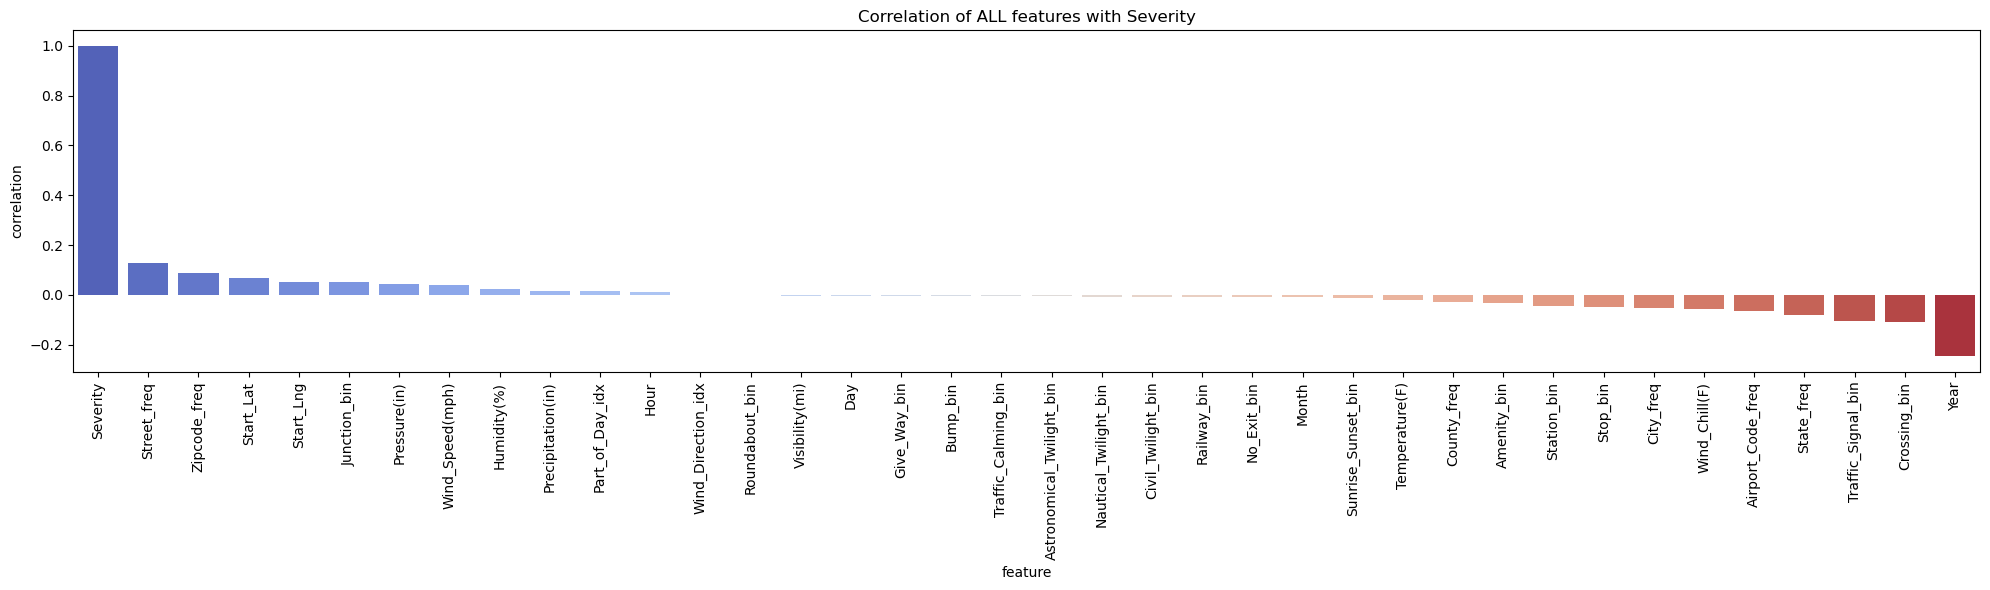

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(
    data=corr_df,
    x="feature",
    y="correlation",
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.title("Correlation of ALL features with Severity")
plt.tight_layout()
plt.show()


## Drop features with corr near 0 

In [ ]:
accidents=accidents.drop("Civil_Twilight_bin","Nautical_Twilight_bin","Astronomical_Twilight_bin",
                         "Traffic_Calming_bin","Bump_bin","Give_Way_bin","Day","Visibility(mi)","Roundabout_bin",
                            "Wind_Direction_idx")


In [ ]:
to_drop = [
    "Civil_Twilight_bin", "Nautical_Twilight_bin", "Astronomical_Twilight_bin",
    "Traffic_Calming_bin", "Bump_bin", "Give_Way_bin",
    "Day", "Visibility(mi)", "Roundabout_bin", "Wind_Direction_idx"
]

corr_df = corr_df[~corr_df["feature"].isin(to_drop)]


/tmp/ipykernel_1050/1198864253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


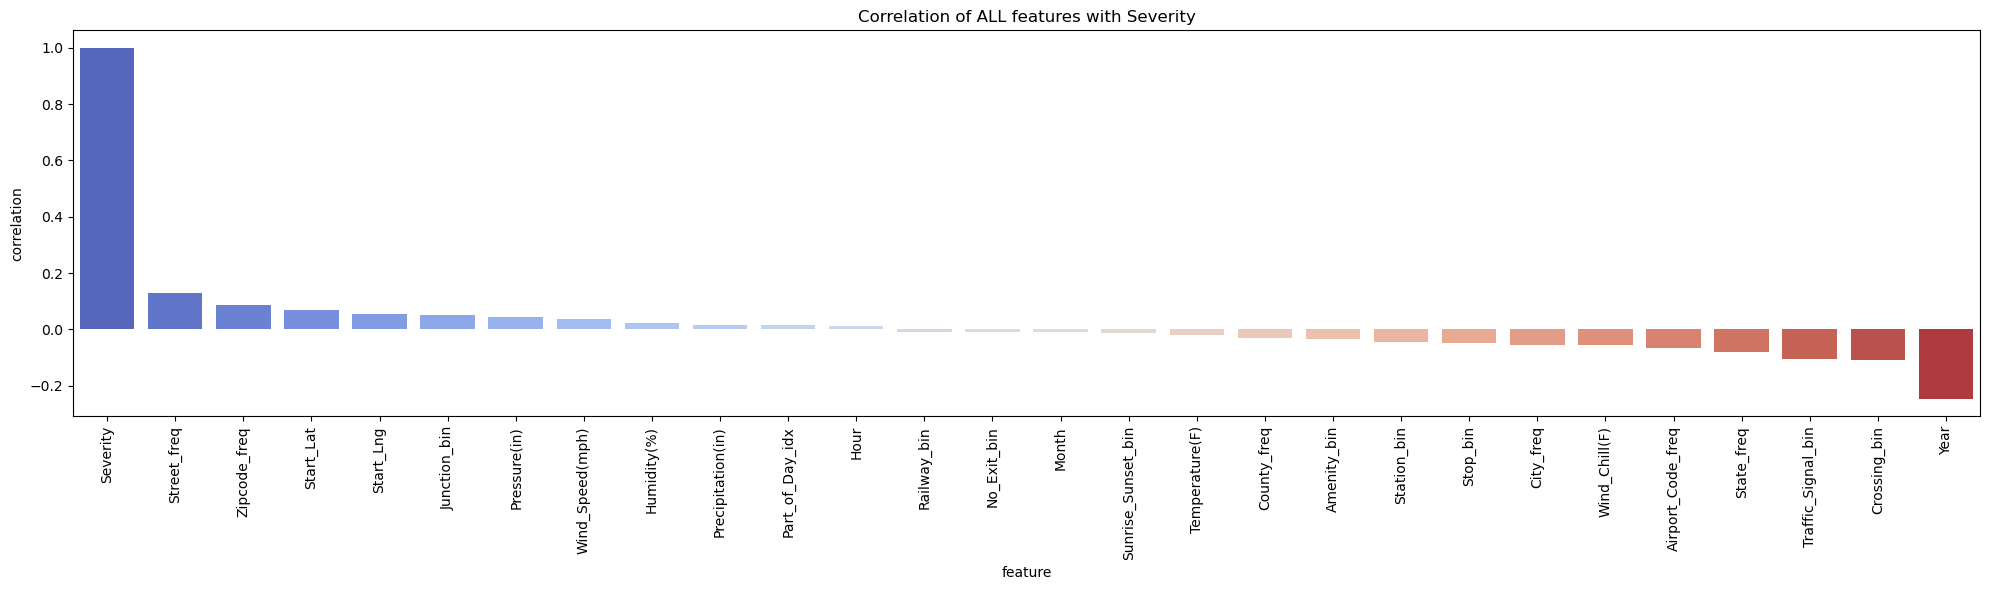

,feature,correlation,abs_correlation
0,Severity,1.000000,1.000000
13,Year,-0.247046,0.247046
16,Street_freq,0.129758,0.129758
28,Crossing_bin,-0.108323,0.108323
37,Traffic_Signal_bin,-0.104901,0.104901
18,Zipcode_freq,0.086977,0.086977
21,State_freq,-0.079342,0.079342
1,Start_Lat,0.069060,0.069060
20,Airport_Code_freq,-0.066717,0.066717
4,Wind_Chill(F),-0.056547,0.056547


In [ ]:

plt.figure(figsize=(20, 6))
sns.barplot(
    data=corr_df,
    x="feature",
    y="correlation",
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.title("Correlation of ALL features with Severity")
plt.tight_layout()
plt.show()
corr_df.sort_values("abs_correlation", ascending=False)

# Class weights

In [ ]:
'''
counts = accidents.groupBy("severity").count().toPandas()
total = counts["count"].sum()

weights = {row["severity"]: total / row["count"] for _, row in counts.iterrows()}
print(weights)

accidents = accidents.withColumn(
    "classWeightCol",
    F.when(F.col("severity") == 1, weights[1])
     .when(F.col("severity") == 2, weights[2])
     .when(F.col("severity") == 3, weights[3])
     .when(F.col("severity") == 4, weights[4])
)'''


# Stratified Train test split

In [ ]:
'''Aggiungi una colonna random per il sort'''
df = accidents.withColumn("rand", F.rand(seed=42))

In [ ]:
'''Ordina per severity e rand (stratified shuffle)

Questo garantisce che le classi siano mescolate ma mantenendo proporzioni identiche'''
df = df.orderBy("severity", "rand")


In [ ]:
'''Split normale (è STRATIFICATO perché il dataset è ordinato!)

Con tantissimi record per classe, questo funziona perfettamente.'''
train, test = df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
from collections import Counter

train_counts = Counter(train.select("severity").rdd.map(lambda r: r[0]).takeSample(False, 500000))
test_counts  = Counter(test.select("severity").rdd.map(lambda r: r[0]).takeSample(False, 500000))

print("TRAIN (sampled):", train_counts)
print("TEST  (sampled):", test_counts)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_com

Py4JError: An error occurred while calling o695.javaToPython

# RandomFprest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="severity",
    #weightCol="classWeightCol",   # <-- importantissimo
    numTrees=10,
    maxDepth=12,
    maxBins=64,
    seed=42
)
